# Tokyo house price prediction

2020/05/18  
Yosuke Kobayashi  
m7142yosuke@gmail.com

---
## このnotebookについて
データ分析を目的として保存されていないデータは非常に汚く、予測や可視化をおこなうには前処理が必要です。  
このnotebookでは東京の住宅価格予測を例にスクレイピングで取得した汚い生のデータを加工し、可視化・予測・精度評価するまでの手順の一例を示します。  
## 分析して得られた知見
## 工夫したこと
* 同じ物件情報を使うことによるデータリークを防いだ。例えば、メゾンという建物で1階と5階で物件が掲載されていたとする。この場合、1階を訓練データ、5階をテストデータとすると、テストの精度は過剰に楽観的になってしまう。そこで物件名でグルーピングして同じ物件名の情報が訓練データとテストデータに別れないようにした。
* 欠損データの補完。例えば、「徒歩十分以内の駅数」は欠損していても「交通情報」は欠損していない場合が多い。そこで交通情報から正規表現を使って徒歩十分圏内の駅数をカウントして補完した。
* 敷金・礼金などの情報は家賃1ヶ月分の金額であることが多いため、そのまま説明変数として使用するとデータリークにつながる。そこで金額という情報を家賃何ヶ月分かという情報に変換して使用した。
* 目的変数の対数変換。目的変数のヒストグラムは右袖が長い分布である。損失関数によっては正規分布から大きく外れた分布だと不都合が生じるため、対数変換により正規分布に近い分布に変換した。また正規分布に近い分布に変換されたことを歪度を使って定量的に評価した。

## 予測精度について
## データの取得方法
2019年末にスクレイピングによりHOME'Sから取得しました。  
約16万5千軒の情報があります。  
※僕がスクレイピングした時点では利用事項にクローリング等を禁止するような文言は見当たりませんでした。

## データ分析結果の活用方法

# データの前処理とEDA
---

## Data description
変数名とその意味
- `name` - 物件名
- `floor` - 階数
- `rent` - 家賃
- `rent_all` - 家賃（共益費）
- `security_deposit ` - 敷金・礼金
- `deposit` - 保証金
- `traffic` - 最寄り駅などの情報
- `address` - 住所
- `number_of_stations_10_min` - 徒歩10分以内の駅数
- `number_of_stations_all` - 近くにある全ての駅の数
- `station_express_info` - 近くの駅の停車する電車の情報（急行・快速など）
- `shopping` - 近くにあるショッピング施設
- `eatting`- 近くにある飲食店
- `education` - 近くにある教育施設
- `hospital`- 近くにある病院
- `bank` - 近くにある銀行
- `public_facility` - 近くにある公共施設
- `how_old` - 築年数
- `new_house` - 新築か否か
- `daylight_direction` - 採光面
- `floor_space` - 床面積
- `balcony_space` - バルコニーの面積
- `floor_plan` - 間取り
- `recomend_point` - おすすめポイント
- `contract_period` - 契約期間
- `renewal_fee` - 更新料
- `deposit2` - 保証金2
- `parking` - 駐車場の有無
- `home_insurance` - 住宅保険
- `status` - 状態（空き家など）
- `pets` - ペットがOKか否か
- `conditions` - 条件
- `kichen` - キッチン等の情報
- `equipments` - 設備の情報
- `structure` - RCなどの建物構造
- `other` - その他の情報
- `separate` - セパレートかどうか
- `url` - 物件のURL

---
## The DATA

In [1]:
model_save = False

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import glob
import warnings
warnings.simplefilter('ignore')
sns.set()

p = Path('./data')
df_all = pd.concat([pd.read_csv(f, index_col=0) for f in p.glob('*.csv')], sort=True)

# 重複した物件を削除
df_all.drop_duplicates(subset='url', keep='first', inplace=True)

pd.set_option('display.max_columns', 100)

In [3]:
df_all.head(2)

,address,air_conditioner,auto_lock,balcony_space,bank,conditions,contract_period,daylight_direction,deposit,deposit2,eatting,education,equipments,equipments2,floor,floor2,floor_plan,floor_space,flooring,home_insurance,hospital,how_old,kichen,location,more_than_2,name,new_house,number_of_stations_10_min,number_of_stations_all,other,parking,pets,public_facility,recomend_point,reheating,renewal_fee,rent,rent_all,security_deposit,separate,shopping,south,station_express_info,status,structure,traffic,url
0,東京都中野区新井5丁目,1.0,1.0,-,\n（株）りそな銀行 中野支店 新井薬師出張所\n中野上高田郵便局\n西武信用金庫 薬師駅前...,\n ...,2年間,南西,- / -,\n -,\n（株）奄美ふくらしゃ\nかざみどり\n竜苑\n季の葩\n豊年屋\n,\nあけぼの保育園\n新井小学校\n大妻中野高等学校\n東亜学園\n目白学園 目白大学 研究...,\n オートロック\n ...,\n クローゼット\n ...,4階/401,4階 / 4階建\n,\n ワンルーム\n ( 洋室 5.8帖(4階)\n1R ),19.28m²,1.0,要,\nクリニックヨコヤマ\n大竹歯科医院\n新渡戸記念中野総合病院\n寺内医院\n総合東京病院\n,2019年7月 ( 新築 ),\n IHコンロ\n ...,\n ...,1.0,FARE中野7,1.0,徒歩10分以内（1駅）,すべての駅（2駅）,\n 保証会社要加入保...,0.0,0.0,\n中野区役所 公園事務所哲学堂公園事務所\n中野区立 上高田図書館\n豊島区役所 区民ひろ...,RC造新築デザイナーズ1Rマンション,1.0,"87,000円",8.7万円,"8.7万円 ( 5,000円 )",8.7万円 / 無,1.0,\nローソンストア１００中野新井四丁目店\nｍｉｎｉピアゴ新井５丁目店\nあらいやくし薬局\...,0.0,西武新宿線 新井薬師前駅 徒歩4分普通準急急行通勤急行ＪＲ中央線 中野駅 徒歩18分普通快速...,空家,\n ...,\n西武新宿線 新井薬師前駅 徒歩4分\nＪＲ中央線 中野駅 徒歩18分\n\n通勤・通学駅...,https://www.homes.co.jp/chintai/b-1064980018577/
1,東京都墨田区東向島3丁目,1.0,1.0,-,\n東京東信用金庫 本店\n東向島一郵便局\n（株）三菱東京ＵＦＪ銀行 向島支店\n向島郵便...,\n 二人入居可\n ...,2年間,北西,- / -,\n ...,\nサンティーニ\n押上せんべい本舗東向島店\nやきとり大吉東向島店\n栄堂\nとんかつひろ\n,\n墨田幼稚園\n第一寺島小学校\n寺島中学校\n東京都立 墨田川高等学校\n千葉工業大学東...,\n オートロック\n ...,\n クローゼット\n ...,2階/-,2階 / 12階建\n,\n 1K\n ( キッチン 2帖(2階)\n洋室 8.5帖(2階) ),26.56m²,1.0,要,\n済生会向島病院\n中林病院\n健生堂病院\n向島医院\n台東区立台東病院\n,2019年11月 ( 新築 ),\n コンロ二口\n ...,\n 二人入居可\n ...,1.0,RELUXIA東向島,1.0,徒歩10分以内（2駅）,すべての駅（3駅）,\n 新築・インター...,1.0,1.0,\n東京都 建設局 向島百花園サービスセンター\n台東区役所 台東区立図書館 石浜\n浅草２...,仲介手数料半額,0.0,新賃料の1ヶ月分,8.5万円,"8.5万円 ( 10,000円 )",無 / 1ヶ月,1.0,\nセブン－イレブン 墨田東向島４丁目店\nグルメシティー東向島駅前店\nあおぞら薬局\n柳...,0.0,東武伊勢崎線 曳舟駅 徒歩6分普通区間準急準急区間急行急行京成押上線 京成曳舟駅 徒歩7分普...,未完成,\n ...,\n東武伊勢崎線 曳舟駅 徒歩6分\n京成押上線 京成曳舟駅 徒歩7分\n東武伊勢崎線 東向...,https://www.homes.co.jp/chintai/b-1313570020198/


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164717 entries, 0 to 東京都三鷹市上連雀
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   address                    164685 non-null  object 
 1   air_conditioner            164716 non-null  float64
 2   auto_lock                  164716 non-null  float64
 3   balcony_space              164685 non-null  object 
 4   bank                       159775 non-null  object 
 5   conditions                 164684 non-null  object 
 6   contract_period            139187 non-null  object 
 7   daylight_direction         164685 non-null  object 
 8   deposit                    164685 non-null  object 
 9   deposit2                   164685 non-null  object 
 10  eatting                    159775 non-null  object 
 11  education                  159775 non-null  object 
 12  equipments                 162071 non-null  object 
 13  equipments2                1420

---
## Data cleaning
EDAやモデルの学習をおこなうために、データクリーニングをします。  
具体的には、以下の処理をしました。
- target変数である`rent`が欠損している行は削除
- すべてobject型になっているので、家賃など数値として扱うものは整数型に変更

In [5]:
df_all.dropna(subset=['rent'], inplace=True)

In [6]:
# 共益費
df_all['service_fee'] = \
    df_all.apply(lambda row: row['rent_all'].lstrip(row['rent']).strip(' ()円').replace(',','').replace('-', '0'), axis=1).astype('int')
df_all.drop('rent_all', axis=1, inplace=True)

In [7]:
df_all['rent'] = df_all['rent'].apply(lambda x: float(x.rstrip('万円'))*10000).astype('int')

## EDA and sample statistics
データの特性を知り、特徴量エンジニアリングやモデルの選定の際に活かします。

### `rent`（家賃）の分布と統計量

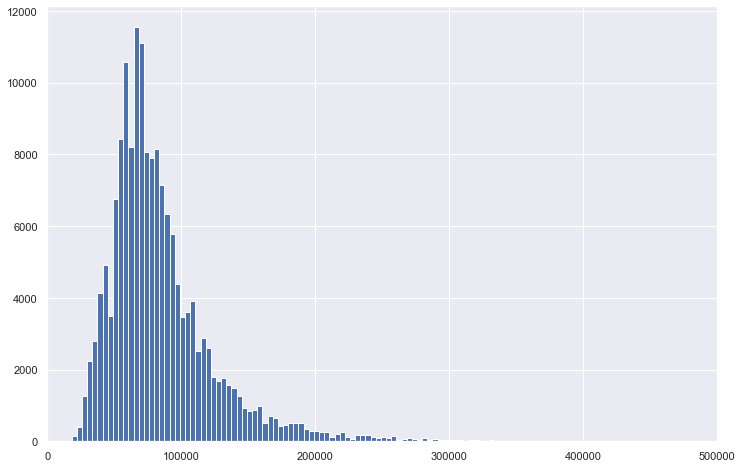

In [8]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['rent'], bins=400)
plt.xlim(0, 500000)
plt.show()

In [9]:
df_all['rent'].describe()

count    1.646850e+05
mean     8.504018e+04
std      4.269391e+04
min      1.050000e+04
25%      6.000000e+04
50%      7.500000e+04
75%      9.900000e+04
max      1.550000e+06
Name: rent, dtype: float64

平均が91652円で、中央値が85000円。さすが東京、高いですね。。

### `service_fee`（共益費）の分布

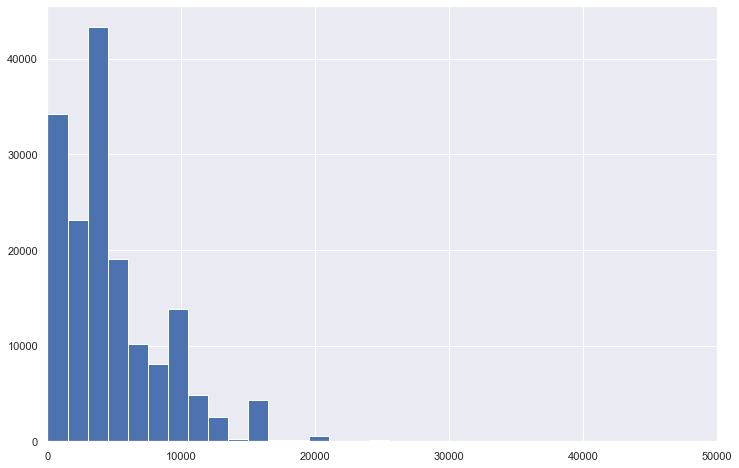

In [10]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['service_fee'], bins=100)
plt.xlim(0, 50000)
plt.show()

In [11]:
df_all['service_fee'].describe()

count    164685.000000
mean       4407.091289
std        3983.448083
min           0.000000
25%        2000.000000
50%        3000.000000
75%        6000.000000
max      150000.000000
Name: service_fee, dtype: float64

共益費はあんまり綺麗な分布ではないですね。

### 目的変数の設定
このデータ分析では`rent`（家賃）と`service_fee`（共益費）を合計した金額を目的変数とします。  

In [12]:
# 目的変数
df_all['target'] = df_all['rent'] + df_all['service_fee']

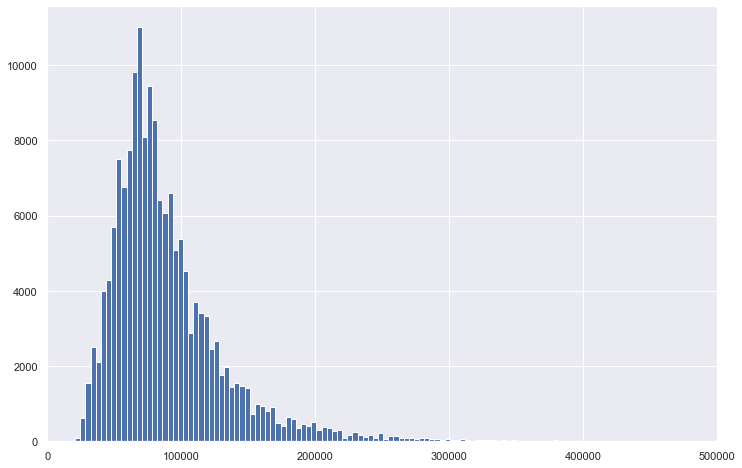

In [13]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['target'], bins=400)
plt.xlim(0, 500000)
plt.show()

右裾が長い分布になっています。  
どれくらい正規分布からズレているか定量的に測ってみましょう。正規分布からのズレ具合を表す統計量として**歪度**があります。  
歪度は`Scipy`を使うことで簡単に計算できます。

In [14]:
import scipy

scipy.stats.skew(df_all['target'])

3.0333404245855253

歪度は1以上だとひどく歪んだ分布なので、東京都の家賃分布はかなり裾が長い分布と言えます。  
田舎だと家賃の幅が狭くて、歪度はもう少し低い値になりそうですね。  

**損失関数によっては、このような正規分布から大きく外れた分布は不都合が生じることがあるため、分布を正規分布に近い形に変換する必要があります。**

### 目的変数の対数変換
目的変数を対数変換することで、分布を正規分布に近づけます。

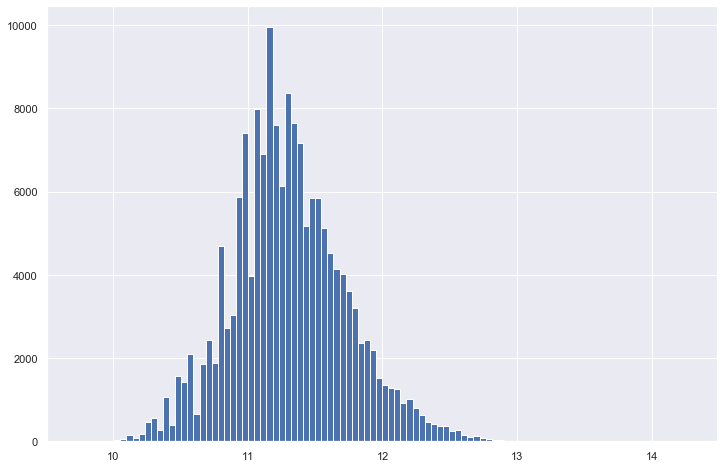

In [15]:
import numpy as np

plt.figure(figsize=(12, 8))
plt.hist(np.log1p(df_all['target']), bins=100)
plt.show()

見た目上、正規分布に近づいていることがわかります。定量的に確認するために、歪度をもう一度計算します。

In [16]:
scipy.stats.skew(np.log1p(df_all['target']))

0.3252554367056249

対数変換によって歪度が大きく減っている（正規分布に近づいていること）が定量的に言えます。（参考：正規分布だと歪度は0になります）

### 徒歩10分圏内の駅の数

In [17]:
df_all['number_of_stations_10_min'].unique()

array(['徒歩10分以内（1駅）', '徒歩10分以内（2駅）', '徒歩10分以内（0駅）', nan, '徒歩10分以内（4駅）',
       '徒歩10分以内（6駅）', '徒歩10分以内（3駅）', '徒歩10分以内（5駅）'], dtype=object)

駅数が欠損しているデータがあります。欠損している行を確認してみます。

In [18]:
df_all[df_all['number_of_stations_10_min'].isnull()].head(2)

,address,air_conditioner,auto_lock,balcony_space,bank,conditions,contract_period,daylight_direction,deposit,deposit2,eatting,education,equipments,equipments2,floor,floor2,floor_plan,floor_space,flooring,home_insurance,hospital,how_old,kichen,location,more_than_2,name,new_house,number_of_stations_10_min,number_of_stations_all,other,parking,pets,public_facility,recomend_point,reheating,renewal_fee,rent,security_deposit,separate,shopping,south,station_express_info,status,structure,traffic,url,service_fee,target
75,東京都府中市是政3丁目64-9,1.0,0.0,-,NaN,\n 二人入居可\n ...,2年間,南東,- / -,\n ...,NaN,NaN,\n TVモニタ付インターホン\n ...,\n ...,1階/102,1階 / 2階建\n,\n 1LDK\n ( ダイニングキッチン 6.2帖\n洋室 5.1帖 ),29.75m²,1.0,要,NaN,2019年9月 ( 新築 ),\n システムキッチン\n ...,\n 二人入居可\n ...,0.0,ファインコーラル,1.0,NaN,NaN,\n 保証会社必須：初...,0.0,0.0,NaN,モニター付きインターフォン・浴室乾燥機・追い焚き・温水洗浄便座・独立洗面台,1.0,新賃料の1ヶ月分,74000,1ヶ月 / 無,1.0,NaN,0.0,ＪＲ南武線 府中本町駅 徒歩11分普通快速西武多摩川線 是政駅 徒歩12分普通,空家,\n ...,\nＪＲ南武線 府中本町駅 徒歩11分\n西武多摩川線 是政駅 徒歩12分\n\n通勤・通学...,https://www.homes.co.jp/chintai/b-1142840600220/,3000,77000
3,東京都文京区本駒込2丁目11,0.0,1.0,-,NaN,\n 二人入居可\n ...,2年間,南東,- / -,\n ...,NaN,NaN,\n オートロック\n ...,\n 全居室収納\n ...,2階/206,2階 / 3階建\n,\n 2LDK\n ( 洋室 4.5帖\n洋室 6.8帖\nリビングダイニング...,56.3m²,1.0,要,NaN,2019年10月 ( 築1年 ),\n コンロ三口\n ...,\n 二人入居可\n ...,1.0,レイ レ ラヴィ,0.0,NaN,NaN,\n お電話でのお問い...,0.0,1.0,NaN,新築物件 即日案内可能 角部屋２面採光 ネット無料 ペット飼育可能,1.0,新賃料の1ヶ月分,158000,1ヶ月 / 1ヶ月,0.0,NaN,0.0,都営三田線 千石駅 徒歩3分普通急行東京メトロ南北線 本駒込駅 徒歩9分普通,空家,\n ...,\n都営三田線 千石駅 徒歩3分\n東京メトロ南北線 本駒込駅 徒歩9分\n都営三田線白山駅...,https://www.homes.co.jp/chintai/b-1408470000244/,4000,162000


駅数が欠損していても、`traffic`から徒歩10分圏内の駅数は0じゃないことがわかります。

### `number_of_stations_10_min`と`number_of_stations_all`の欠損値の補完
欠損していない`traffic`から文字を抽出して、欠損している駅数を補完します。

In [19]:
df_all['traffic'].iloc[0]

'\n西武新宿線 新井薬師前駅 徒歩4分\nＪＲ中央線 中野駅 徒歩18分\n\n通勤・通学駅までの経路・所要時間を調べる\n\n'

上の文から10分以内の駅数、家の近くのすべての駅数を抽出できそうです。

In [20]:
import re

def count_10min_stations(col):
    stations = 0
    for i in col.splitlines():
        if 'バス' not in i:
            stations += len(re.findall('徒歩[0-9]分|徒歩10分', i))
    return stations

def count_near_stations(col):
    # ??駅 徒歩xx分という文の数をカウントして、駅数を求める。
    stations = len(re.findall('徒歩\d+分', col))
    try:
        # 他に??駅が利用可能という文から??駅を抽出
        stations += int(re.findall('に\d+駅', col)[0].strip('駅に'))
    except:
        # 他に??駅が利用可能という文が存在しない場合、配列外参照エラーがでるため例外処理しています。
        pass
    return stations

In [21]:
# 徒歩10分以内の駅数
# df_all['number_of_stations_10_min'] = df_all['traffic'].apply(lambda x: len(re.findall('徒歩[0-9]|10分', x))).astype('int')
df_all['number_of_stations_10_min'] = df_all['traffic'].apply(count_10min_stations).astype('int')
# 家の近くのすべての駅数
df_all['number_of_stations_all'] = df_all['traffic'].apply(count_near_stations).astype('int')

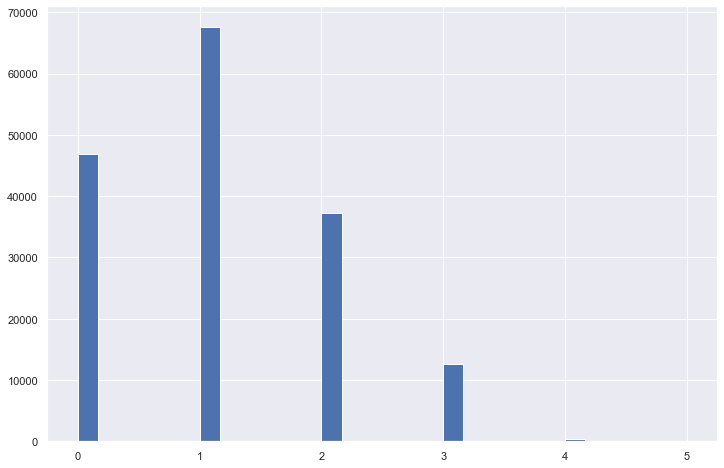

In [22]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['number_of_stations_10_min'], bins=30)
plt.show()

In [23]:
df_all['number_of_stations_10_min'].value_counts()

1    67601
0    46957
2    37202
3    12612
4      311
5        2
Name: number_of_stations_10_min, dtype: int64

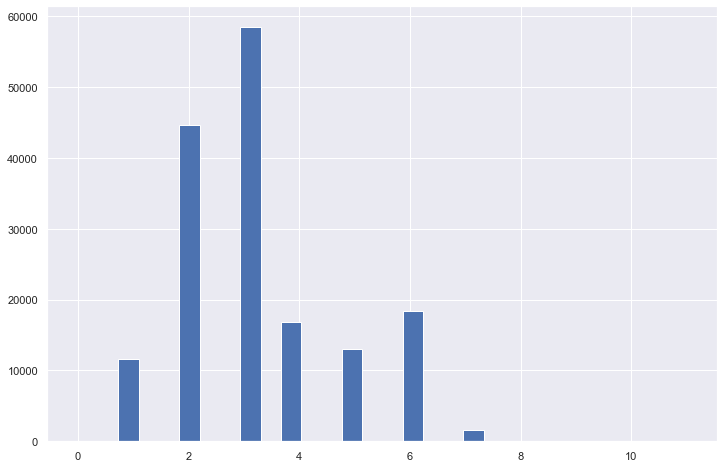

In [24]:
plt.figure(figsize=(12, 8))
plt.hist(df_all['number_of_stations_all'], bins=30)
plt.show()

In [25]:
df_all['number_of_stations_all'].value_counts()

3     58456
2     44683
6     18414
4     16810
5     13067
1     11577
7      1627
0        44
8         4
10        2
11        1
Name: number_of_stations_all, dtype: int64

### 1,2,3番目に近い駅を抽出

In [26]:
df_all.reset_index(drop=True, inplace=True)

In [27]:
first_near_station = [None for s in range(len(df_all))]
second_near_station = [None for s in range(len(df_all))]
third_near_station = [None for s in range(len(df_all))]

for index in df_all.index:
    stations_list = [s for s in df_all.loc[index, 'traffic'].splitlines() if ('通勤・通学駅' not in s) and ('他に' not in s) and s]
    for i, station in enumerate(stations_list):
        if i==0:
            # index=8の国立のように国立駅の駅が抜けている場合があるため例外処理
            try:
                first_near_station[index] = re.findall('.*駅', station)[0]
            except:
                first_near_station[index] = None
        elif i==1:
            try:
                second_near_station[index] = re.findall('.*駅', station)[0]
            except:
                second_near_station[index] = None
        elif i==2:
            try:
                third_near_station[index] = re.findall('.*駅', station)[0]
            except:
                third_near_station[index] = None

df_all['first_near_station'] = first_near_station
df_all['second_near_station'] = second_near_station
df_all['third_near_station'] = third_near_station

### 床面積

In [28]:
df_all['floor_space'] = df_all['floor_space'].apply(lambda x: x.rstrip('m²').replace(',', '')).astype('float')

### 築年数

In [29]:
# 築0年のときは新築と記載されているので、築0年に置き換える。
df_all['how_old'] = df_all['how_old'].apply(lambda x: re.findall(' 築(\d+)年 ', x.replace('新築', '築0年'))[0]).astype('int')

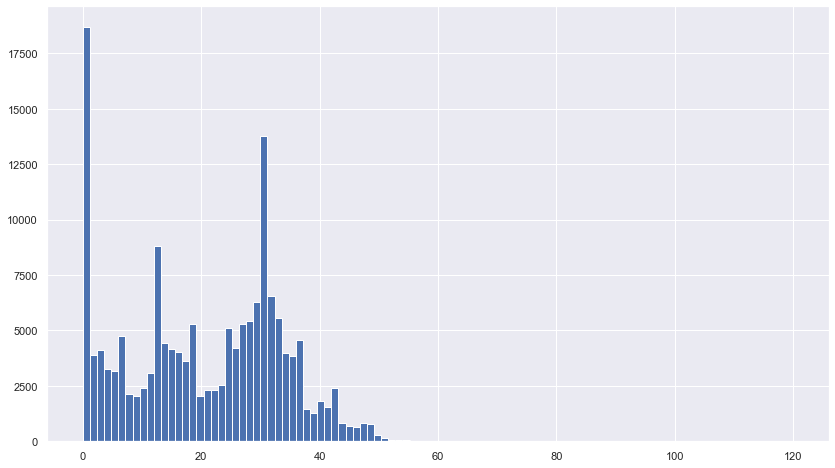

In [30]:
plt.figure(figsize=(14,8))
plt.hist(df_all['how_old'], bins=100)
plt.show()

### 敷金・礼金
敷金・礼金をそのまま使うとデータリークするため、金額が記載されている場合は、何か月分の家賃かに置換する。

In [31]:
df_all['key_money'] = df_all['security_deposit'].apply(lambda x: x.split(' / ')[1])
df_all['security_deposit'] = df_all['security_deposit'].apply(lambda x: x.split(' / ')[0])

In [32]:
def preprocess_security_deposit(row):
    if 'ヶ月' in row['security_deposit']:
        # 正規表現で小数点を含む数字を取得
        how_months = float(re.findall('(\d*[.,]?\d*)ヶ月', row['security_deposit'])[0])
    elif '万円' in row['security_deposit']:
        money = float(re.findall('(\d*[.,]?\d*)万円', row['security_deposit'])[0])*10000
        how_months = money/row['rent']
    elif '無'== row['security_deposit']:
        how_months = 0
    else:
        raise Exception
    return how_months

def preprocess_key_money(row):
    if 'ヶ月' in row['key_money']:
        how_months = float(re.findall('(\d*[.,]?\d*)ヶ月', row['key_money'])[0])
    elif '万円' in row['key_money']:
        money = float(re.findall('(\d*[.,]?\d*)万円', row['key_money'])[0])*10000
        how_months = money/row['rent']
    elif '無'== row['key_money']:
        how_months = 0
    else:
        raise Exception
    return how_months

df_all['security_deposit'] = df_all.apply(preprocess_security_deposit, axis=1)
df_all['key_money'] = df_all.apply(preprocess_key_money, axis=1)

### 更新料

In [33]:
def preprocess_renewal_fee(row):
    # nanを含んでいる場合、文字型でないとエラーがでる。
    if 'ヶ月' in str(row['renewal_fee']):
        how_months = float(re.findall('新賃料の(\d*[.,]?\d*)ヶ月分', row['renewal_fee'])[0])
    elif '円' in str(row['renewal_fee']):
        money = float(re.sub(',|円', '', row['renewal_fee']))
        how_months = money/row['rent']
    else:
        how_months = 0
    return how_months

df_all['renewal_fee'] = df_all.apply(preprocess_renewal_fee, axis=1)

### 最寄り駅までの時間

In [34]:
df_all['time_to_go_nearest_station'] = \
        df_all['traffic'].apply(lambda x: re.findall('徒歩(\d+)分', x)[0] if '徒歩' in x else None).astype('float')

### 階数

301階なるものが存在しますが、中国で構想段階の300階建てのビル（1228m）に匹敵する高さなので明らかに間違いです笑  
3階になおしておきます。

In [35]:
df_all[df_all['name']=='ロイヤルコートＫａｙＡＢ'].floor

38283    301階/B206
Name: floor, dtype: object

In [36]:
df_all.loc[df_all[df_all['name']=='ロイヤルコートＫａｙＡＢ'].index, 'floor'] = '3階'

In [37]:
df_all[['floor2','floor']]

,floor2,floor
0,4階 / 4階建\n,4階/401
1,2階 / 12階建\n,2階/-
2,3階 / 12階建\n,3階/-
3,2階 / 3階建\n,2階/205
4,2階 / 3階建\n,2階/201
...,...,...
164680,4階 / 9階建\n,4階/-
164681,2階 / 9階建\n,2階/-
164682,1階 / 2階建\n,1階/-
164683,2階 / 2階建\n,NaN


In [38]:
def extract_max_foor(row):
    try:
        if '階' in str(row):
            max_floor = re.findall('(\d+)階', row)[1]
        else:
            max_floor = None
    except:
        max_floor = None
    return max_floor

In [39]:
df_all['max_floor'] = df_all['floor2'].apply(extract_max_foor).astype('float')

In [40]:
df_all['floor'] = df_all['floor2'].apply(lambda x: re.findall('(\d+)階', x)[0] if '階' in str(x) else 0).astype('int')

In [41]:
df_all.drop(['rent', 'service_fee'], axis=1, inplace=True)

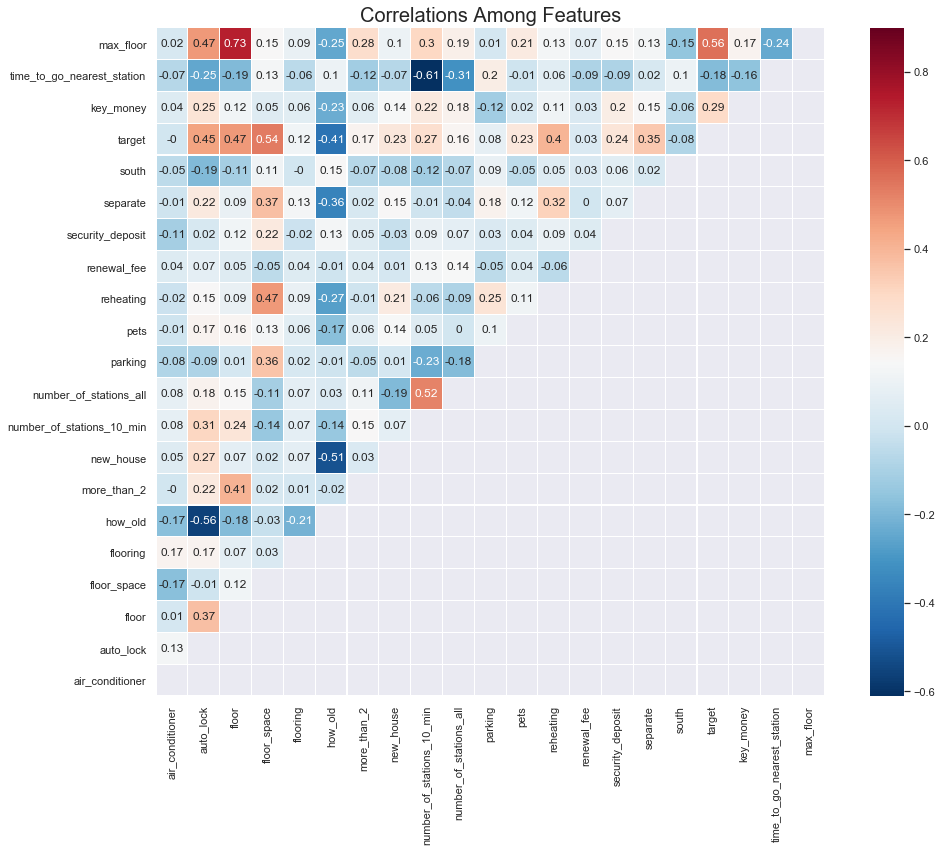

In [42]:
mask = np.zeros_like(df_all.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (15,12))
sns.heatmap(df_all.corr().round(decimals=2), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20)
plt.tight_layout()
plt.ylim(0,len(df_all.corr()))
plt.show()

### ヒートマップからわかること
- `auto_lock`と家賃の相関がやや大きい。ただし、`auto_lock`は築年数と大きな負の相関があり、これは`auto_lock`が導入され始めたのが比較的新しいためだと考えられる。  
したがって、家賃とオートロックは疑似相関（築年数を介した）の可能性が高い

## 偏相関係数の算出
家賃とオートロックの有無は相関があるように見えるが築年数という第三の変数を介した疑似相関である可能性があることに言及した。  
そこで偏相関係数を算出することで本当にそれらが疑似相関かどうかを定量的に見積もってみる。

In [43]:
from pingouin import partial_corr

partial_corr(data=df_all, x='auto_lock', y='target', covar='how_old', method='pearson')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,164685,0.301203,"[0.3, 0.31]",0.090723,0.090712,0.0,inf,1.0


家賃とオートロックの相関係数は0.45だったが、第三の変数を築年数とした擬似相関は0.30となった。  
したがって、築年数の影響を除いた後の家賃とオートロックの関係はさほど強くないことがわかる。

### 間取り
|アルファベット  |意味  |
|---|---|
|R  |一般的に1部屋の中にキッチンが含まれている間取り  |
|K  |居室とキッチンの間に間仕切りがある間取り  |
|D  |キッチンで食事がとれるようなスペースがある  |
|L  |食事やテレビを見たりできるようなダイニングよりもさらに広いスペースがある  |
|S  |サービスルームの略。採光が不足し居室とは認められないがフリースペースとして使える部屋  |

参考：https://suumo.jp/yougo/m/madori/

In [44]:
df_all['floor_plan'] = df_all['floor_plan'].apply(lambda x: x.split()[0])

In [45]:
df_all['floor_plan'].unique()

array(['ワンルーム', '1K', '1LDK', '1DK', '3LDK', '2K', '2LDK', '2DK', '2SLDK',
       '1SK', '1SLDK', '3DK', '1SDK', '1SLK', '3K', '2SDK', '1LK',
       '3SLDK', '4DK', '4LDK', '4SLDK', '3SDK', '10K', '2LK', '5SLDK',
       '5DK', '2R', '4K', '2SLK', '5K', '2SK', '5LDK', '3LK', '6R', '15K',
       '3SK', '5SK', '4SDK', '11K', '8LDK', '6LDK', '7LDK', '5SDK',
       '6SLDK', '3SLK', '6DK', '12DK', '7SLDK', '4SK'], dtype=object)

### 住所

In [46]:
df_all['address_town'] = df_all['address'].apply(lambda x: re.split('\d+', x)[0])

In [47]:
def extract_city_name(row):
    if re.findall('東京都(.+区)', row):
        return re.findall('東京都(.+区)', row)[0]
    elif re.findall('東京都(.+市)', row):
        return re.findall('東京都(.+市)', row)[0]
    elif re.findall('東京都(.+郡)', row):
        return re.findall('東京都(.+郡)', row)[0]

In [48]:
df_all['city'] = df_all['address'].apply(extract_city_name)

In [49]:
def extract_town_name(row):
    row = row.replace('-', '丁目')
    try:
        return [s for s in re.findall('(東京都.+区\D+)\d+丁目|(東京都.+市\D+)\d+丁目|(東京都.+郡\D+)\d+丁目', row)[0] if len(s)>0][0]
    except:
        return ""

In [50]:
df_all['town'] = df_all['address'].apply(extract_town_name)

In [51]:
numeric_col = [s for s in df_all.columns if df_all[s].dtype != 'object']
object_col = ['city', 'floor_plan', 'first_near_station', 'second_near_station', 'third_near_station', 'status', 'address', 'address_town', 'name', 'url', 'structure']

In [52]:
df = df_all[numeric_col + object_col]

In [53]:
df['target'] = np.log1p(df['target'].copy())

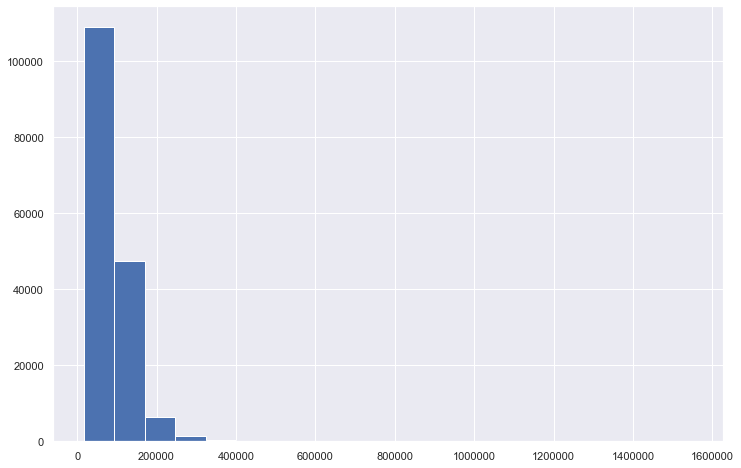

In [54]:
plt.figure(figsize=(12, 8))
plt.hist(np.ceil(df_all['target']), bins=20)
plt.show()

In [55]:
import geopandas as gpd

# get from https://github.com/dataofjapan/land
df_tokyomap = gpd.read_file('./data/tokyo.geojson')
df_toshin = df_tokyomap[df_tokyomap['area_en'] == 'Tokubu'].copy()
df_toshin['mean'] = [df_all.groupby('city').mean()[['target']].loc[s].target for s in df_toshin.ward_ja]
df_toshin['coords'] = df_toshin.geometry.apply(lambda x: x.representative_point().coords[:][0])

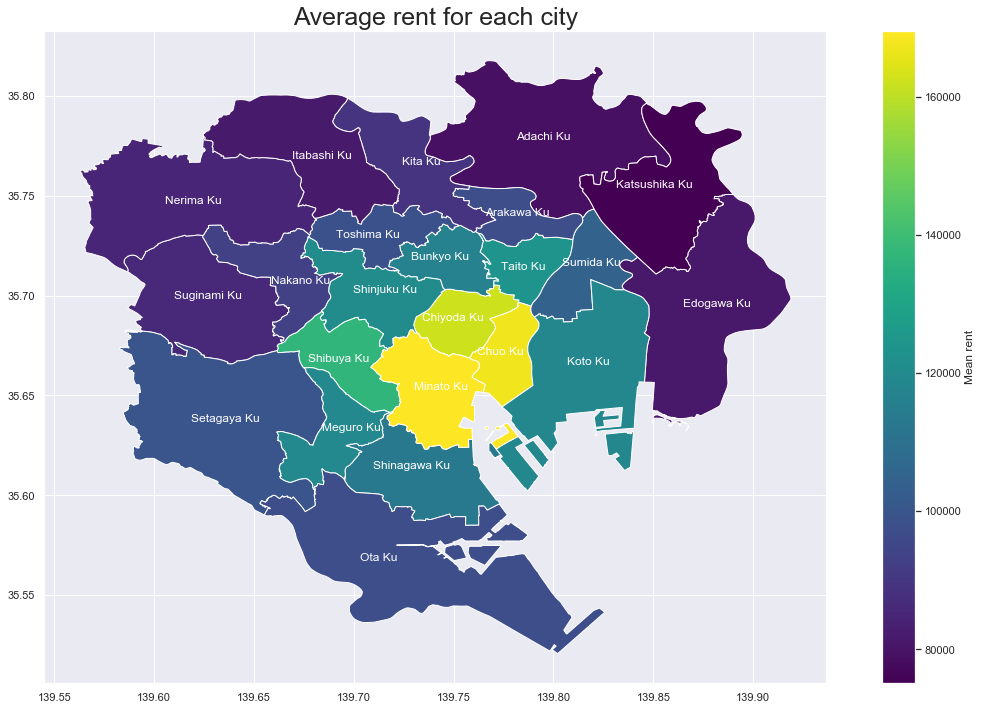

In [56]:
df_toshin.plot(column='mean', figsize=(20,12), legend=True, legend_kwds={'label': "Mean rent"}, cmap='viridis')
for idx, row in df_toshin.iterrows():
    plt.annotate(s=row['ward_en'], xy=row['coords'],
                 horizontalalignment='center', color='white')
plt.title('Average rent for each city', fontsize=25)
plt.show()

港区、中央区を中心として放射線状に価格が分布していることがわかる。

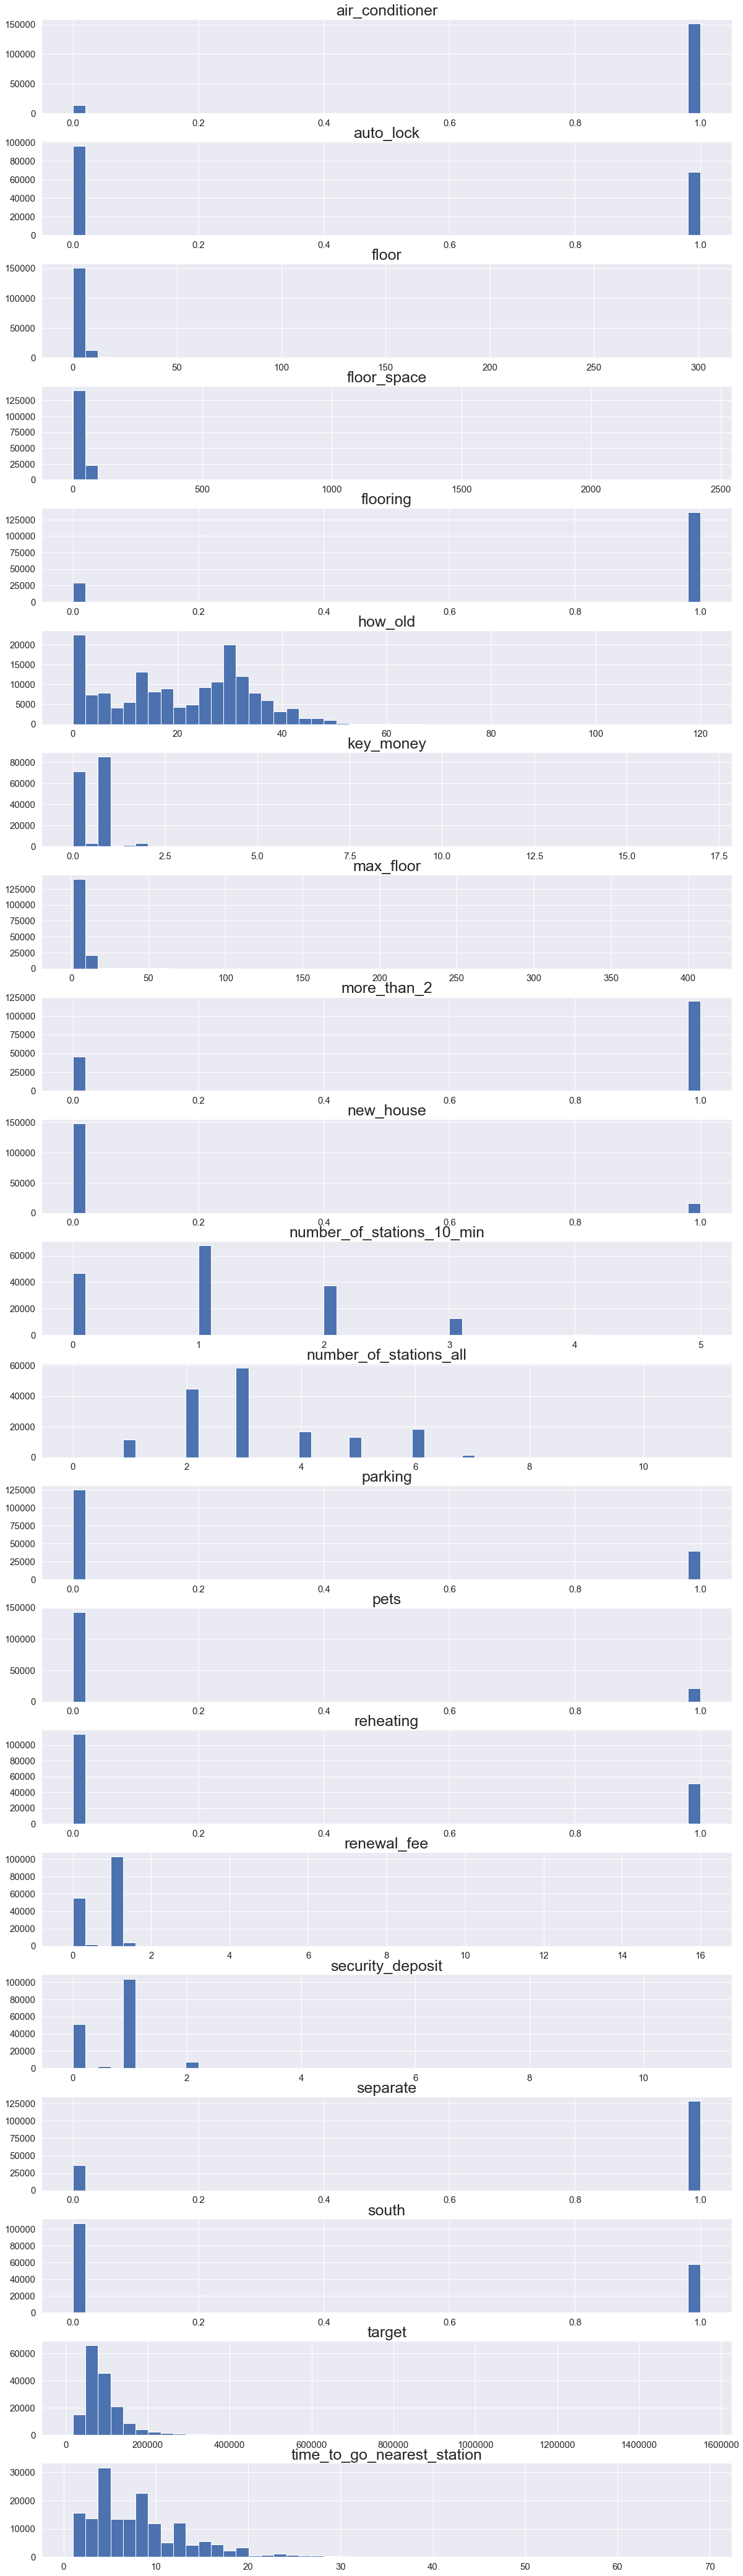

In [57]:
fig = df_all.hist(bins=50, figsize=(20,90), layout=(25, 1), xlabelsize=15, ylabelsize=15)
[x.title.set_size(25) for x in fig.ravel()]
plt.show()

In [58]:
from sklearn.preprocessing import LabelEncoder

encoder_dict = {}
for col in object_col:
    if col != 'url':
        df[col].fillna('-999', inplace=True)
        encoder_dict[col] = LabelEncoder().fit(df[col])
        df[col] = encoder_dict[col].transform(df[col].copy())

# 機械学習モデルの作成
---

In [59]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

X = df.drop('target', axis=1)
y = df['target'].values
for train_idx, test_idx in gss.split(X, y, groups=X['name'].values):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]    

In [60]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
nfold = 3
# folds = KFold(n_splits=nfold, shuffle=True, random_state=42)
folds = GroupKFold(n_splits=nfold)
groups = X_train['name'].values
print('-'*20)
print(str(nfold) + ' Folds training...')
print('-'*20)

--------------------
3 Folds training...
--------------------


In [61]:
params_lgb = {
    "boosting": "gbdt",
    "verbosity": -1,
    "num_leaves": 200,
#     "min_data_in_leaf": 10,
    "min_child_weight": 1,
    "max_depth": 8,
    "colsample_bytree": 1.0,
    "subsample": 0.9,
    "gamma": 0,
    "lambda_l2": 1,
    "lambda_l1": 0,
    "learning_rate": 0.1,
    "random_seed": 42,
    "metric": "rmse",
}

In [62]:
%%time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

oof = np.zeros(len(X_train))
feature_importance_df = pd.DataFrame()
df_fold_all = pd.DataFrame()
tr_rmse = []
val_rmse = []
models = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train, groups)):
    strLog = f"fold {fold_}"
    print(strLog)
    df_fold_id = pd.DataFrame(data={'index':val_idx})
    df_fold_id['folds'] = fold_
    df_fold_all = pd.concat([df_fold_all, df_fold_id])
    
    X_tr, X_val = X_train.drop(['url', 'name'], axis=1).iloc[trn_idx], X_train.drop(['url', 'name'], axis=1).iloc[val_idx]
    y_tr, y_val = y_train[trn_idx], y_train[val_idx]
    
    model = lgb.LGBMRegressor(**params_lgb, n_estimators = 100000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='rmse',
              verbose=500, 
              early_stopping_rounds=500,
             )

    oof[val_idx] = model.predict(X_val)
    val_score = np.sqrt(mean_squared_error(y_val, oof[val_idx]))
    val_rmse.append(val_score)
    tr_score = np.sqrt(mean_squared_error(y_tr, model.predict(X_tr)))
    tr_rmse.append(tr_score)
    models.append(model)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.booster_.feature_importance(importance_type='gain')[:len(X_tr.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(oof)))
df_fold_all.set_index('index', inplace=True)
print(f'RMSE {rmse}円')

fold 0
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.0631642	valid_1's rmse: 0.0986051
[1000]	training's rmse: 0.0495684	valid_1's rmse: 0.0959534
[1500]	training's rmse: 0.0414072	valid_1's rmse: 0.0948733
[2000]	training's rmse: 0.0354313	valid_1's rmse: 0.0943384
[2500]	training's rmse: 0.0304207	valid_1's rmse: 0.093974
[3000]	training's rmse: 0.0267761	valid_1's rmse: 0.0937303
[3500]	training's rmse: 0.0237264	valid_1's rmse: 0.0935834
[4000]	training's rmse: 0.0212886	valid_1's rmse: 0.0934899
[4500]	training's rmse: 0.0192518	valid_1's rmse: 0.0934278
[5000]	training's rmse: 0.0174473	valid_1's rmse: 0.0933583
[5500]	training's rmse: 0.0159835	valid_1's rmse: 0.0933249
[6000]	training's rmse: 0.014847	valid_1's rmse: 0.0933065
[6500]	training's rmse: 0.0137962	valid_1's rmse: 0.0933026
[7000]	training's rmse: 0.012819	valid_1's rmse: 0.0932903
[7500]	training's rmse: 0.0120236	valid_1's rmse: 0.0932908
[8000]	training's rmse: 0.0113391	v

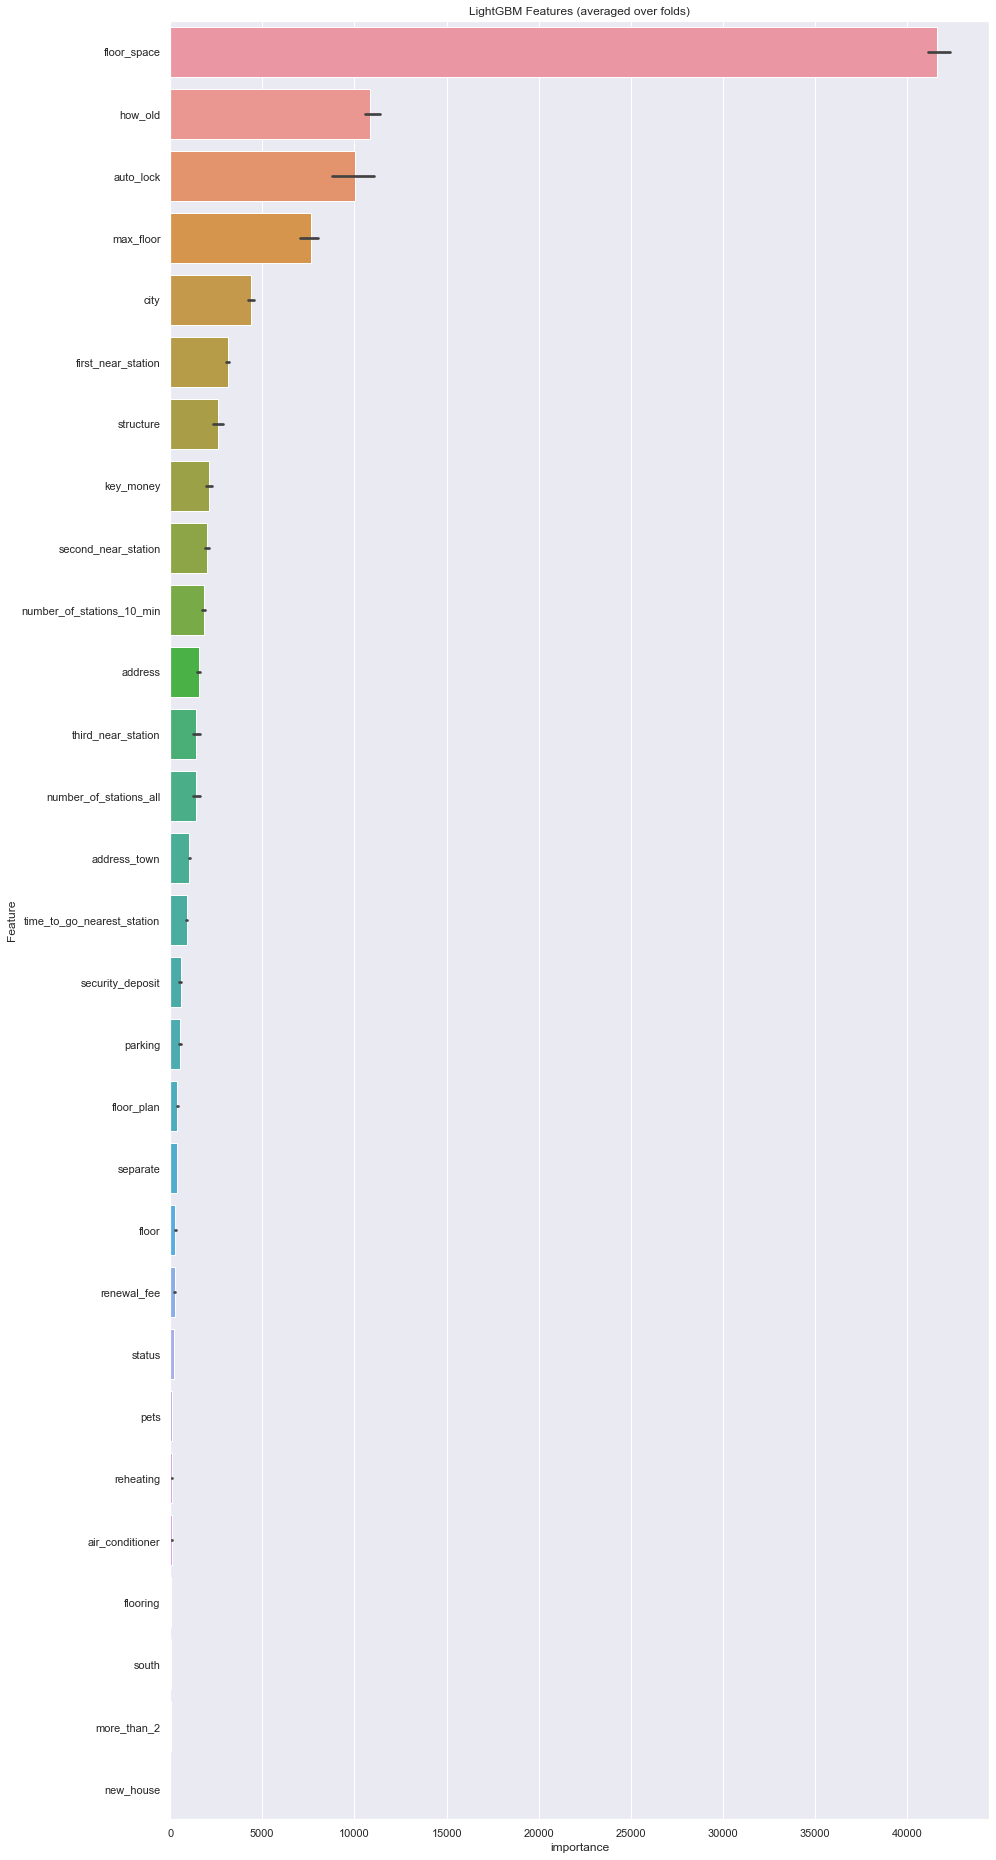

In [63]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

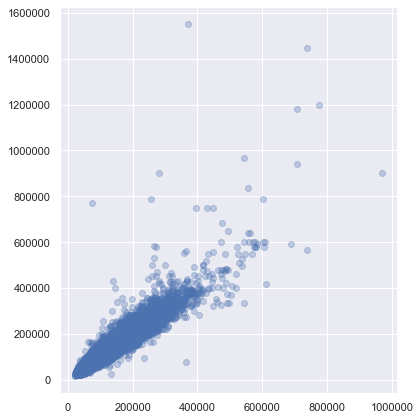

In [64]:
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(oof), np.expm1(y_train), alpha=0.3)
plt.tight_layout()
plt.show()

In [65]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 相対誤差

In [66]:
mean_absolute_percentage_error(np.expm1(y_train), np.expm1(oof))

6.413988179078574

In [67]:
def calc_sc(x):
    return np.round_(50+10*(x-np.average(x))/np.std(x))

In [68]:
if model_save:
    for idx, model in enumerate(models):
        model.booster_.save_model(f'./data/lgb_regressor_{idx}.txt')
    X_train = X_train.reset_index(drop=True).join(df_fold_all)
    X_train['target'] = np.expm1(y_train)
    X_train['predict'] = np.expm1(oof)
    X_train['mape'] = X_train.apply(lambda x: (x['predict']-x['target'])/x['target'], axis=1)
    X_train['sc'] = calc_sc(X_train['mape'])
    X_train.to_csv('./data/x_train.csv', index=False)

In [82]:
!rm -r 不動産価格予測_files
!jupyter nbconvert --to markdown 不動産価格予測.ipynb
!mv 不動産価格予測.md README.md

[NbConvertApp] Converting notebook 不動産価格予測.ipynb to markdown
[NbConvertApp] Support files will be in 不動産価格予測_files/
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Making directory 不動産価格予測_files
[NbConvertApp] Writing 44214 bytes to 不動産価格予測.md


In [70]:
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

# geolocator = Nominatim()
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [71]:
# location_dict = {}
# for i,s in enumerate(df_all.town.unique()):
#     print(i)
#     if s:
#         loc = geocode(s)
#         if loc:
#             location_dict[s] = loc[1]

In [72]:
# pd.DataFrame.from_dict({'location': location_dict}).to_csv('data/location.csv')

In [73]:
import ast

df_loc = pd.read_csv('data/location.csv', index_col=0, converters={"location": ast.literal_eval})

In [74]:
# import geopandas

# gdf = geopandas.GeoDataFrame(
#     index=df_loc.index, geometry=geopandas.points_from_xy([s[0] for s in df_loc.location], [s[1] for s in df_loc.location]))

In [75]:
df_loc['latitude'] = [s[0] for s in df_loc.location]
df_loc['longitude'] = [s[1] for s in df_loc.location]

In [77]:
df_loc_target = pd.merge(df_all[df_all.town.isin(df_loc.index)].groupby('town').mean()[['time_to_go_nearest_station']], df_loc ,left_index=True, right_index=True)

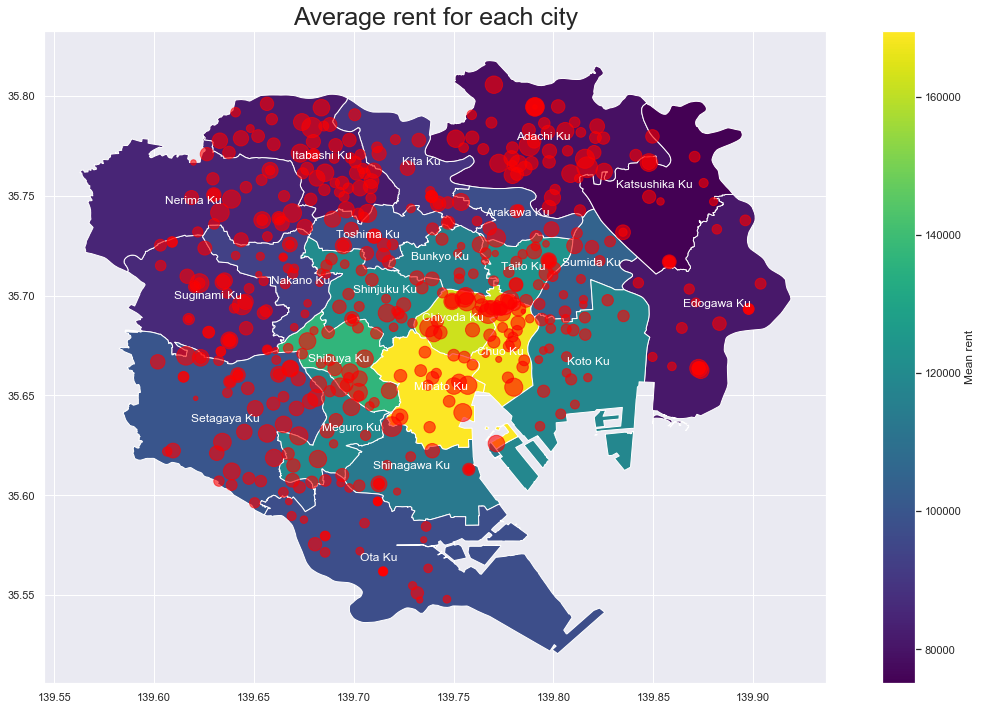

In [78]:
df_toshin.plot(column='mean', figsize=(20,12), legend=True, legend_kwds={'label': "Mean rent"}, cmap='viridis')
for idx, row in df_toshin.iterrows():
    plt.annotate(s=row['ward_en'], xy=row['coords'],
                 horizontalalignment='center', color='white')
plt.scatter(df_loc_target[(df_loc_target.latitude >=35) & (df_loc_target.longitude >= 139.6)].longitude,
            df_loc_target[(df_loc_target.latitude >=35) & (df_loc_target.longitude >= 139.6)].latitude,
            s=df_loc_target.time_to_go_nearest_station*20, alpha=0.6, c='red')
plt.title('Average rent for each city', fontsize=25)
plt.show()

In [79]:
df_temp = df_all.groupby('town').target.agg(['mean', 'count'])

In [80]:
df_temp[df_temp['count'] >= 10].sort_values(by='mean', ascending=False).head(30)

,mean,count
town,,
東京都千代田区三番町,333375.000000,24
東京都千代田区西神田,303043.478261,23
東京都中央区晴海,280552.183908,87
東京都港区東新橋,250750.000000,24
東京都港区虎ノ門,225257.575758,33
東京都渋谷区恵比寿西,224439.393939,33
東京都中央区勝どき,222157.746479,355
東京都江東区有明,211911.764706,34
東京都渋谷区松濤,211909.090909,11


In [81]:
df_temp[df_temp['count'] >= 10].sort_values(by='mean').head(30)

,mean,count
town,,
東京都日野市程久保,40216.571429,175
東京都八王子市滝山町,42206.896552,29
東京都西東京市緑町,43578.947368,19
東京都町田市忠生,44971.264368,87
東京都武蔵村山市中藤,44991.666667,12
東京都多摩市山王下,45514.285714,35
東京都八王子市丹木町,46466.019417,103
東京都八王子市寺町,46678.571429,14
東京都多摩市馬引沢,46726.027397,146
